In [1]:
import numpy as np
import ogb
from ogb.nodeproppred import PygNodePropPredDataset
from torch_geometric.data import DataLoader
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from utils import get_nx_graph, color_mapper, draw_legend

In [2]:
d_name = 'ogbn-mag'
dataset = PygNodePropPredDataset(name=d_name) 

split_idx = dataset.get_idx_split() 

In [3]:
# print some info about the dataset
print(dataset.num_classes)
print(dataset.is_hetero)
print('----')

data = dataset[0]
print(data.num_nodes)
print(data.num_edges)

349
True
----
{'author': 1134649, 'field_of_study': 59965, 'institution': 8740, 'paper': 736389}
None


In [4]:
print(data.edge_index_dict[('author', 'writes', 'paper')])
print(data.node_year['paper'].shape)

tensor([[      0,       0,       0,  ..., 1134647, 1134648, 1134648],
        [  19703,  289285,  311768,  ...,  657395,  671118,  719594]])
torch.Size([736389, 1])


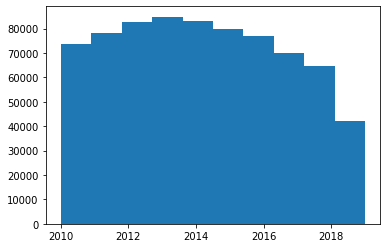

In [5]:
# inspect years
years = data.node_year['paper'].numpy()
plt.figure()
plt.hist(years)
plt.show()
plt.close()

In [6]:
# filter papers based on years

threshold = 2010
selection = set(np.where(years<=threshold)[0].tolist())

In [7]:
# filter edges based on the above

edges = data.edge_index_dict[('author', 'writes', 'paper')].numpy().T
filtered_edges = [(a, b) for (a, b) in edges if b in selection]

In [8]:
# project on papers

author_to_paper = dict()
paper_to_author = dict()
for edge in filtered_edges:
    author, paper = edge
    if author not in author_to_paper:
        author_to_paper[author] = set()
    author_to_paper[author].add(paper)
    if paper not in paper_to_author:
        paper_to_author[paper] = set()
    paper_to_author[paper].add(author) 

simplices = {}
for paper in paper_to_author:
    k = len(paper_to_author[paper])
    if k not in simplices:
        simplices[k] = set()
    simplices[k].add(paper)

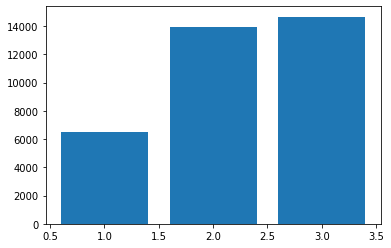

In [9]:
# inspect k distribution

max_k = 3
k_representations = {k: len(simplices[k]) for k in simplices if k <= max_k}
x = sorted(k_representations.keys())
y = [k_representations[k] for k in x]

plt.figure()
plt.bar(x, y)
plt.show()
plt.close()

In [10]:
# how many facets if we only consider up to triangles?

count = 0
for k in range(1, max_k + 1):
    count += k_representations[k]
print(count)

35127


In [11]:
# what about the same authors writing multiple papers?

authors_to_paper = dict()
for paper in paper_to_author:
    authors = tuple(sorted(paper_to_author[paper]))
    if authors not in authors_to_paper:
        authors_to_paper[authors] = list()
    authors_to_paper[authors].append(paper)
    
print(len(authors_to_paper), len(paper_to_author))

69921 73553


number of overall unique facets:  66866


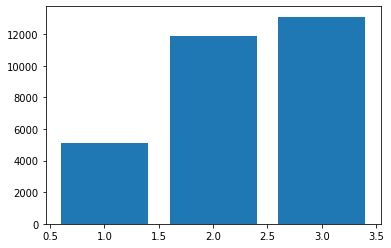

number of unique facets up to k=3:  30123


In [12]:
# let's discard those cases for now

unique_author_to_paper = dict()
for authors in authors_to_paper:
    if len(authors_to_paper[authors]) == 1:
        unique_author_to_paper[authors] = authors_to_paper[authors][0]
        
unique_paper_to_author = dict()
for authors in unique_author_to_paper:
    unique_paper_to_author[unique_author_to_paper[authors]] = authors

print('number of overall unique facets: ', len(unique_paper_to_author))

unique_facets = dict()
for paper in unique_paper_to_author:
    k = len(unique_paper_to_author[paper])
    if k not in unique_facets:
        unique_facets[k] = set()
    unique_facets[k].add(paper)

max_k = 3
unique_k_frequencies = {k: len(unique_facets[k]) for k in unique_facets if k <= max_k}
x = sorted(unique_k_frequencies.keys())
y = [unique_k_frequencies[k] for k in x]

plt.figure()
plt.bar(x, y)
plt.show()
plt.close()

count = 0
for k in range(1, max_k + 1):
    count += unique_k_frequencies[k]
print('number of unique facets up to k={}: '.format(max_k), count)

In [13]:
# sample even more for now

import random
num_papers = 5000
paper_list = list(unique_paper_to_author.keys())
random.shuffle(paper_list)
sample = set(paper_list[:num_papers])

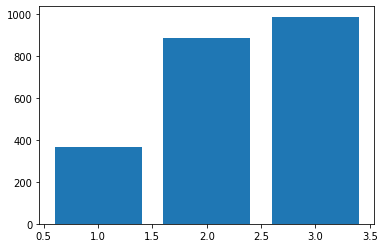

number of unique facets up to k=3:  2241


In [14]:
sampled_unique_facets = dict()
for paper in unique_paper_to_author:
    k = len(unique_paper_to_author[paper])
    if k not in sampled_unique_facets:
        sampled_unique_facets[k] = set()
    if paper in sample:
        sampled_unique_facets[k].add(paper)

max_k = 3
sampled_unique_k_frequencies = {k: len(sampled_unique_facets[k]) for k in sampled_unique_facets if k <= max_k}
x = sorted(sampled_unique_k_frequencies.keys())
y = [sampled_unique_k_frequencies[k] for k in x]

plt.figure()
plt.bar(x, y)
plt.show()
plt.close()

count = 0
for k in range(1, max_k+1):
    count += sampled_unique_k_frequencies[k]
print('number of unique facets up to k={}: '.format(max_k), count)

In [16]:
# ok, let's try to connect them
# ... we will start by constructing upper adjacencies
# we can start from facets and then recur down

import itertools as it

def get_faces(simplex, as_sets=True):
    k = len(simplex)
    if k == 1:
        raise ValueError("0-simplices do not have faces.")
    if as_sets:
        return set([set(face) for face in it.combinations(simplex, len(simplex)-1)])
    else:
        return set([tuple(sorted(comb)) for comb in it.combinations(simplex, len(simplex)-1)])

def fill_upper_adjs(nodes, all_simplices, non_facets, not_in_sample, upper_adjacencies):
    
    # keep track of the simplices encountered;
    # ... and those which do not correspond to any facet (they
    # won't have features assigned as they don't match any paper)
    nodes = tuple(sorted(nodes))
    all_simplices.add(nodes)
    if nodes not in unique_author_to_paper:
        non_facets.add(nodes)
    else:
        paper = unique_author_to_paper[nodes]
        if paper not in sample:
            not_in_sample.add(paper)
    
    # stop recursion if nodea have been reached
    k = len(nodes)
    if k == 1:
        return all_simplices, non_facets, not_in_sample, upper_adjacencies
    
    # get faces of the input simplex: all of them are
    # considered to be upper adjacent
    faces = get_faces(nodes, as_sets=False)
    for face in faces:
            
        # add adjacencies to all other faces in the simplex
        if face not in upper_adjacencies[k-1]:
            upper_adjacencies[k-1][face] = set()
        upper_adjacencies[k-1][face] |= faces - {face}
        
        # recur down
        all_simplices, non_facets, in_sample, upper_adjacencies = fill_upper_adjs(face, all_simplices, non_facets, not_in_sample, upper_adjacencies)

    return all_simplices, non_facets, not_in_sample, upper_adjacencies

all_simplices = set()
non_facets = set()
not_in_sample = set()
upper_adjacencies = dict()
for k in range(1, max_k):
    upper_adjacencies[k] = dict()

for k in range(1, max_k+1):
    facets = sampled_unique_facets[k]
    for facet in facets:
        nodes = paper_to_author[facet]
        assert tuple(sorted(nodes)) in unique_author_to_paper
        all_simplices, non_facets, not_in_sample, upper_adjacencies = fill_upper_adjs(nodes, all_simplices, non_facets, not_in_sample, upper_adjacencies)

In [17]:
len(all_simplices)

9799

In [18]:
len(non_facets)

7366

In [19]:
len(all_simplices - non_facets)

2433

In [20]:
len(not_in_sample) == len(all_simplices - non_facets) - count

True

In [21]:
all_simplices_by_key = dict()
for simplex in all_simplices:
    k = len(simplex)
    if k not in all_simplices_by_key:
        all_simplices_by_key[k] = list()
    all_simplices_by_key[k].append(simplex)

In [ ]:
def lower_adj(a, b, min_k=1):
    assert len(a) == len(b)
    k = len(a)
    intersection = tuple(sorted(set(a) & set(b)))
    return intersection in all_simplices and len(intersection) == k - 1 and k > min_k

# lower
lower_adjacencies = dict()
for k in range(2, max_k+1):
    lower_adjacencies[k] = dict()
    
for k in range(1, max_k+1):
    simplices = all_simplices_by_key[k]
    for p in range(len(simplices)):
        for pp in range(p+1, len(simplices)):
            nodes_p = simplices[p]
            nodes_pp = simplices[pp]
            if lower_adj(nodes_p, nodes_pp):
                if nodes_p not in lower_adjacencies[k]:
                    lower_adjacencies[k][nodes_p] = set()
                if nodes_pp not in lower_adjacencies[k]:
                    lower_adjacencies[k][nodes_pp] = set()
                lower_adjacencies[k][nodes_p].add(nodes_pp)
                lower_adjacencies[k][nodes_pp].add(nodes_p)

In [ ]:
lower_adj[3]

In [404]:
def edge_dict_to_edge_lists(lower_adjacency, upper_adjacency):
    pass

In [ ]:
# can we get the connectivity between simplices?

import itertools as it

def lower_adj(a, b, get_simplices_fn, min_k=1):
    assert len(a) == len(b)
    k = len(a)
    intersection = a & b
    associated_simplices = get_simplices_fn(tuple(sorted(intersection)))
    if len(associated_simplices) > 0 and k > min_k:
        return True, associated_simplices
    else:
        return False, associated_simplices

def upper_adj(a, b, get_simplices_fn, max_k=3):
    assert len(a) == len(b)
    k = len(a)
    union = a | b
    associated_simplices = get_simplices_fn(tuple(sorted(union)))
    if len(associated_simplices) > 0 and k < max_k:
        return True, associated_simplices
    else:
        return False, associated_simplices

def get_faces(simplex, as_sets=True):
    k = len(simplex)
    if k == 1:
        raise ValueError("0-simplices do not have faces.")
    if as_sets:
        return set([set(face) for face in it.combinations(simplex, len(simplex)-1)])
    else:
        return set([tuple(sorted(comb)) for comb in it.combinations(simplex, len(simplex)-1)])
    
def get_possible_cofaces(simplex, support, as_sets=True, max_k=None):
    k = len(simplex)
    if max_k is not None and k >= len(support):
        raise ValueError("{}-simplices cannot have cofaces.".format(k))
    others = support - simplex
    if as_sets:
        return set([simplex|{node} for node in others])
    else:
        return set([tuple(sorted(simplex|{node})) for node in others])

In [ ]:
%%time

def get_simplices_fn(x):
    if x not in authors_to_paper:
        return list()
    else:
        return authors_to_paper[x]
    
facet_upper_connectivity = {}
facet_lower_connectivity = {}
max_k = 3
for k in range(1, max_k+1):
    papers = sorted(list(simplices[k]))
    facet_lower_connectivity[k] = list()
    facet_upper_connectivity[k] = list()
    for p in range(len(papers)):
        for pp in range(p+1, len(papers)):
            nodes_p = paper_to_author[papers[p]]
            nodes_pp = paper_to_author[papers[pp]]
            if lower_adj(nodes_p, nodes_pp, get_simplices_fn)[0]:
                facet_lower_connectivity[k].append((papers[p], papers[pp]))
                facet_lower_connectivity[k].append((papers[pp], papers[p]))
            if upper_adj(nodes_p, nodes_pp, get_simplices_fn, max_k=max_k)[0]:
                facet_upper_connectivity[k].append((papers[p], papers[pp]))
                facet_upper_connectivity[k].append((papers[pp], papers[p]))

In [198]:
import time
def get_facet_upper_adj(simplices, k, min_k, max_k, get_nodes_fn, get_simplices_fn):
    if k >= max_k or k < min_k:
        return list()
    edge_list_upper = list()
    above = simplices[k+1]
    k_facets = set([tuple(sorted(get_nodes_fn(simplex))) for simplex in simplices[k]])
    for simplex in above:
        # 1. get nodes
        nodes = get_nodes_fn(simplex)
        # 2. get faces
        faces = get_faces(nodes, as_sets=False)
        # 3. intersect with k-facets
        selection = faces & k_facets
        # 4. retrieve simplices from the selection
        adj_simplices = list()
#         if len(selection) > 1:
#             import pdb; pdb.set_trace()
        for nodes in selection:
            adj_simplices += get_simplices_fn(nodes)
        # 5. create connections
        connections = list(it.product(adj_simplices, repeat=2))
        # 6. remove self-loops and add
        edge_list_upper += [(a, b) for (a, b) in connections if a != b]
    return edge_list_upper


def get_facet_lower_adj(simplices, k, min_k, max_k, get_nodes_fn, get_simplices_fn, num_nodes):
    if k > max_k or k <= min_k:
        return list()
    support = set(list(range(num_nodes)))
    edge_list_lower = list()
    below = simplices[k-1]
    k_facets = set([tuple(sorted(get_nodes_fn(simplex))) for simplex in simplices[k]])
    for s, simplex in enumerate(below):
        print('\r{}/{}    '.format(s, len(below)), end='')
        # 1. get nodes
        nodes = get_nodes_fn(simplex)
        # 2. get co-faces
        cofaces = get_possible_cofaces(nodes, support, as_sets=False)
        # 3. intersect with k-facets
        selection = cofaces & k_facets
        # 4. retrieve simplices from the selection
        adj_simplices = list()
#         if len(selection) > 1:
#             import pdb; pdb.set_trace()
        for nodes in selection:
            adj_simplices += get_simplices_fn(nodes)
        # 5. create connections
        connections = list(it.product(adj_simplices, repeat=2))
        # 6. remove self-loops and add
        edge_list_lower += [(a, b) for (a, b) in connections if a != b]
    return edge_list_lower

In [199]:
%%time
res = get_facet_lower_adj(simplices, 2, 1, 3, lambda x: paper_to_author[x], lambda x: authors_to_paper[x], len(paper_to_author))

126/6494    

KeyboardInterrupt: 